In [1]:
import numpy as np
import pandas as pd
import keras
import zipfile
import tensorflow as tf

#Models and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.applications.vgg16 import VGG16
#optimizers TO be extended
from keras.optimizers import Adam, RMSprop, SGD

#stopping
from keras.callbacks import EarlyStopping, ModelCheckpoint

#visualizing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from keras_preprocessing.image import img_to_array, array_to_img, load_img, ImageDataGenerator

In [2]:
ziploc= "E:/School/UU/PATREC/CXR_project/NEW_DATA/"
augmented_image_loc = "E:/School/UU/PATREC/PR_images/"
og_image_loc = "E:/School/UU/PATREC/.darwin/datasets/v7-labs/covid-19-chest-x-ray-dataset/images/"
store_model_loc = "E:/School/UU/PATREC/checkpoints/"
all_img_loc = "E:/School/UU/PATREC/PR_images/ALL/"

In [3]:
trainzip =  zipfile.ZipFile(ziploc+'final_train_data.zip') 
train_df = pd.read_csv(trainzip.open('train_final.csv'))
valzip =  zipfile.ZipFile(ziploc+'final_val_data.zip') 
val_df = pd.read_csv(valzip.open('val_final.csv'))
testzip =  zipfile.ZipFile(ziploc+'final_test_data.zip') 
test_df = pd.read_csv(testzip.open('test_final.csv'))

In [4]:
seed = 4
datagenerator =  ImageDataGenerator(rescale= 1/255)

# Make train rescled
train_data = datagenerator.flow_from_dataframe(
        dataframe = train_df,
        directory = all_img_loc,
        x_col = "ogfilename",
        y_col = "label",
        class_mode = "categorical",
        batch_size = 60,
        seed = seed,
        shuffle = True,
        target_size = (224,224), # changed values for vgg16
        keep_aspect_ratio = True,
        validate_filenames= True)

# Make val data
val_data = datagenerator.flow_from_dataframe(
        dataframe = val_df,
        directory = all_img_loc,
        x_col = "ogfilename",
        y_col = "label",
        class_mode = "categorical",
        batch_size = 40,
        seed = seed,
        shuffle = True,
        target_size = (224,224), # changed values for vgg16
        keep_aspect_ratio = True,
        validate_filenames= True)

# Make test data
test_data = datagenerator.flow_from_dataframe(
        dataframe = test_df,
        directory = all_img_loc,
        x_col = "ogfilename",
        y_col = None,
        class_mode = None,
        batch_size = 1,
        seed = seed,
        shuffle = False,
        target_size = (224,224), # changed values for vgg16
        keep_aspect_ratio = True,
        validate_filenames= True)

Found 9119 validated image filenames belonging to 4 classes.
Found 1139 validated image filenames belonging to 4 classes.
Found 635 validated image filenames.


In [5]:
def get_model(weight, include_top_layer, input_size, trainable, classes):
    vgg =  VGG16(weights=weight, include_top=include_top_layer, input_shape = input_size)
    model = Sequential()
    model.add(vgg)
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(classes, activation='softmax'))
    model.layers[0].trainable = trainable
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                  metrics=["accuracy"])
    return model

In [6]:
imagenet_model = get_model('imagenet', False, (224,224,3), False, 4)
imagenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4)                 100356    
                                                                 
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
imagenet_free_model = get_model('imagenet', include_top_layer=False, input_size=(224,224,3), trainable=True, classes=4)
imagenet_free_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 14,815,044
Trainable params: 14,815,044
Non-trainable params: 0
_________________________________________________________________


In [8]:
def fit_model(modelname, storeloc, pat):
    checkpoint = ModelCheckpoint(storeloc, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    es = EarlyStopping(monitor='val_accuracy', patience=pat)
    callbacks_list = [checkpoint, es]

    history = modelname.fit(
        train_data,
        steps_per_epoch=50,
        epochs=120,
        validation_data=val_data,
        validation_steps=28,
        callbacks = callbacks_list,
    )
    return history

In [9]:
imagenet_model_history = fit_model(imagenet_model,store_model_loc,7)


Epoch 1/120
50/50 [==============================] - ETA: 0s - loss: 1.3432 - accuracy: 0.3747
Epoch 1: val_accuracy improved from -inf to 0.71161, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 74s 1s/step - loss: 1.3432 - accuracy: 0.3747 - val_loss: 0.9472 - val_accuracy: 0.7116
Epoch 2/120
50/50 [==============================] - ETA: 0s - loss: 1.0526 - accuracy: 0.5393
Epoch 2: val_accuracy improved from 0.71161 to 0.74911, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 39s 785ms/step - loss: 1.0526 - accuracy: 0.5393 - val_loss: 0.7856 - val_accuracy: 0.7491
Epoch 3/120
50/50 [==============================] - ETA: 0s - loss: 0.9055 - accuracy: 0.6212
Epoch 3: val_accuracy improved from 0.74911 to 0.75714, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 31s 623ms/step - loss: 0.9055 - accuracy: 0.6212 - val_loss: 0.6944 - val_accuracy: 0.7571
Epoch 4/120
50/50 [==============================] - ETA: 0s - loss: 0.7960 - accuracy: 0.6776
Epoch 4: val_accuracy improved from 0.75714 to 0.77500, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 26s 511ms/step - loss: 0.7960 - accuracy: 0.6776 - val_loss: 0.6434 - val_accuracy: 0.7750
Epoch 5/120
50/50 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.7062
Epoch 5: val_accuracy improved from 0.77500 to 0.79911, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 23s 458ms/step - loss: 0.7384 - accuracy: 0.7062 - val_loss: 0.6016 - val_accuracy: 0.7991
Epoch 6/120
50/50 [==============================] - ETA: 0s - loss: 0.7309 - accuracy: 0.7070
Epoch 6: val_accuracy did not improve from 0.79911
50/50 [==============================] - 19s 369ms/step - loss: 0.7309 - accuracy: 0.7070 - val_loss: 0.5916 - val_accuracy: 0.7920
Epoch 7/120
50/50 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.7257
Epoch 7: val_accuracy improved from 0.79911 to 0.81339, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 21s 420ms/step - loss: 0.6976 - accuracy: 0.7257 - val_loss: 0.5568 - val_accuracy: 0.8134
Epoch 8/120
50/50 [==============================] - ETA: 0s - loss: 0.6423 - accuracy: 0.7450
Epoch 8: val_accuracy improved from 0.81339 to 0.81429, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 21s 413ms/step - loss: 0.6423 - accuracy: 0.7450 - val_loss: 0.5410 - val_accuracy: 0.8143
Epoch 9/120
50/50 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.7457
Epoch 9: val_accuracy improved from 0.81429 to 0.81964, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 21s 414ms/step - loss: 0.6438 - accuracy: 0.7457 - val_loss: 0.5267 - val_accuracy: 0.8196
Epoch 10/120
50/50 [==============================] - ETA: 0s - loss: 0.6241 - accuracy: 0.7539
Epoch 10: val_accuracy did not improve from 0.81964
50/50 [==============================] - 19s 372ms/step - loss: 0.6241 - accuracy: 0.7539 - val_loss: 0.5256 - val_accuracy: 0.8179
Epoch 11/120
50/50 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.7559
Epoch 11: val_accuracy improved from 0.81964 to 0.82500, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 21s 423ms/step - loss: 0.6161 - accuracy: 0.7559 - val_loss: 0.5140 - val_accuracy: 0.8250
Epoch 12/120
50/50 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.7687
Epoch 12: val_accuracy did not improve from 0.82500
50/50 [==============================] - 19s 370ms/step - loss: 0.5914 - accuracy: 0.7687 - val_loss: 0.5065 - val_accuracy: 0.8223
Epoch 13/120
50/50 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.7796
Epoch 13: val_accuracy improved from 0.82500 to 0.83661, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 21s 420ms/step - loss: 0.5650 - accuracy: 0.7796 - val_loss: 0.4910 - val_accuracy: 0.8366
Epoch 14/120
50/50 [==============================] - ETA: 0s - loss: 0.5590 - accuracy: 0.7799
Epoch 14: val_accuracy did not improve from 0.83661
50/50 [==============================] - 19s 370ms/step - loss: 0.5590 - accuracy: 0.7799 - val_loss: 0.4900 - val_accuracy: 0.8295
Epoch 15/120
50/50 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.7747
Epoch 15: val_accuracy did not improve from 0.83661
50/50 [==============================] - 19s 372ms/step - loss: 0.5664 - accuracy: 0.7747 - val_loss: 0.4829 - val_accuracy: 0.8348
Epoch 16/120
50/50 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.7833
Epoch 16: val_accuracy improved from 0.83661 to 0.83750, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 21s 414ms/step - loss: 0.5519 - accuracy: 0.7833 - val_loss: 0.4775 - val_accuracy: 0.8375
Epoch 17/120
50/50 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.7916
Epoch 17: val_accuracy did not improve from 0.83750
50/50 [==============================] - 18s 361ms/step - loss: 0.5418 - accuracy: 0.7916 - val_loss: 0.4826 - val_accuracy: 0.8259
Epoch 18/120
50/50 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7930
Epoch 18: val_accuracy improved from 0.83750 to 0.84107, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 21s 421ms/step - loss: 0.5348 - accuracy: 0.7930 - val_loss: 0.4723 - val_accuracy: 0.8411
Epoch 19/120
50/50 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.7893
Epoch 19: val_accuracy did not improve from 0.84107
50/50 [==============================] - 19s 370ms/step - loss: 0.5390 - accuracy: 0.7893 - val_loss: 0.4698 - val_accuracy: 0.8393
Epoch 20/120
50/50 [==============================] - ETA: 0s - loss: 0.5246 - accuracy: 0.7963
Epoch 20: val_accuracy improved from 0.84107 to 0.84286, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 22s 428ms/step - loss: 0.5246 - accuracy: 0.7963 - val_loss: 0.4610 - val_accuracy: 0.8429
Epoch 21/120
50/50 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.8023
Epoch 21: val_accuracy improved from 0.84286 to 0.84375, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 21s 410ms/step - loss: 0.5256 - accuracy: 0.8023 - val_loss: 0.4611 - val_accuracy: 0.8438
Epoch 22/120
50/50 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.8073
Epoch 22: val_accuracy did not improve from 0.84375
50/50 [==============================] - 19s 372ms/step - loss: 0.4956 - accuracy: 0.8073 - val_loss: 0.4663 - val_accuracy: 0.8348
Epoch 23/120
50/50 [==============================] - ETA: 0s - loss: 0.5086 - accuracy: 0.8077
Epoch 23: val_accuracy improved from 0.84375 to 0.84464, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 21s 430ms/step - loss: 0.5086 - accuracy: 0.8077 - val_loss: 0.4520 - val_accuracy: 0.8446
Epoch 24/120
50/50 [==============================] - ETA: 0s - loss: 0.4964 - accuracy: 0.8069
Epoch 24: val_accuracy did not improve from 0.84464
50/50 [==============================] - 19s 371ms/step - loss: 0.4964 - accuracy: 0.8069 - val_loss: 0.4533 - val_accuracy: 0.8420
Epoch 25/120
50/50 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.8093
Epoch 25: val_accuracy did not improve from 0.84464
50/50 [==============================] - 18s 362ms/step - loss: 0.4977 - accuracy: 0.8093 - val_loss: 0.4522 - val_accuracy: 0.8446
Epoch 26/120
50/50 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.8183
Epoch 26: val_accuracy did not improve from 0.84464
50/50 [==============================] - 18s 360ms/step - loss: 0.4649 - accuracy: 0.8183 - val_loss: 0.4525 - val_accuracy: 0.8321
Epoch 27/120
50/50 [========

INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 21s 418ms/step - loss: 0.4946 - accuracy: 0.8040 - val_loss: 0.4445 - val_accuracy: 0.8482
Epoch 29/120
50/50 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.8140
Epoch 29: val_accuracy did not improve from 0.84821
50/50 [==============================] - 19s 372ms/step - loss: 0.4933 - accuracy: 0.8140 - val_loss: 0.4520 - val_accuracy: 0.8286
Epoch 30/120
50/50 [==============================] - ETA: 0s - loss: 0.4739 - accuracy: 0.8103
Epoch 30: val_accuracy did not improve from 0.84821
50/50 [==============================] - 18s 361ms/step - loss: 0.4739 - accuracy: 0.8103 - val_loss: 0.4397 - val_accuracy: 0.8402
Epoch 31/120
50/50 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.8073
Epoch 31: val_accuracy did not improve from 0.84821
50/50 [==============================] - 19s 375ms/step - loss: 0.4764 - accuracy: 0.8073 - val_loss: 0.4574 - val_accuracy: 0.8339
Epoch 32/120
50/50 [========

In [10]:
def evaluate(model, test_data, test_df):
    y_prediction = model.predict(test_data) #for each observation the model returns the probability of belonging to each class 
    y_prediction = np.argmax(y_prediction, axis=1) #choose the class with most probability

    #Create confusion matrix and normalizes it over predicted (columns)
    result = confusion_matrix(test_df.label, y_prediction, normalize='pred')
    result2 = result.astype('float') / result.sum(axis=1)[:, np.newaxis]
    acc_perclass = result.diagonal()
    report = classification_report(test_df.label, y_prediction)
    return result, acc_perclass, report

635/635 [==============================] - 19s 29ms/step


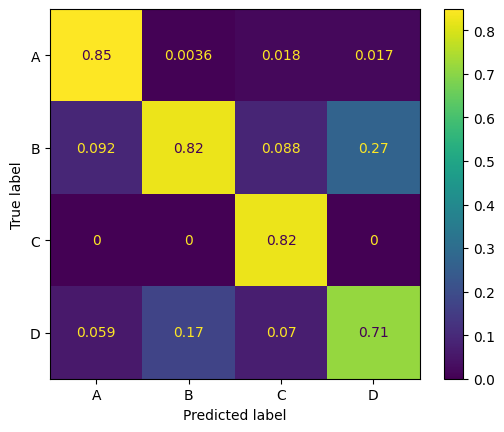

In [11]:
#Predict
y_prediction_IN_model = imagenet_model.predict(test_data) #for each observation the model returns the probability of belonging to each class
arg_y_IN_model = np.argmax(y_prediction_IN_model, axis=1) #choose the class with most probability
a = {0:'A',1:'B',2:'C',3:'D'}
## print(list(test_df.label))
## print([a[i] for i in arg_y_INF_model])
result_IN = confusion_matrix(list(test_df.label), [a[i] for i in arg_y_IN_model], normalize='pred')
cm_display_IN = ConfusionMatrixDisplay(confusion_matrix = result_IN, display_labels = ['A','B','C','D'])
cm_display_IN.plot()
plt.show()

In [12]:
acc_perclass_IN = result_IN.diagonal()
print("Accuracy per class Model 1")
print(acc_perclass_IN)
print("Healthy      Bacterial     Covid     Viral")


Accuracy per class Model 1
[0.84864865 0.82374101 0.8245614  0.71304348]
Healthy      Bacterial     Covid     Viral


In [13]:
print(classification_report(test_df.label, [a[i] for i in arg_y_IN_model]))

              precision    recall  f1-score   support

           A       0.85      0.98      0.91       161
           B       0.82      0.81      0.82       282
           C       0.82      1.00      0.90        47
           D       0.71      0.57      0.63       145

    accuracy                           0.81       635
   macro avg       0.80      0.84      0.81       635
weighted avg       0.80      0.81      0.80       635



### Unfrozen

In [14]:
imagenet_free_model_history = fit_model(imagenet_free_model,store_model_loc,7)

Epoch 1/120
50/50 [==============================] - ETA: 0s - loss: 1.0673 - accuracy: 0.5262
Epoch 1: val_accuracy improved from -inf to 0.76071, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 71s 1s/step - loss: 1.0673 - accuracy: 0.5262 - val_loss: 0.6323 - val_accuracy: 0.7607
Epoch 2/120
50/50 [==============================] - ETA: 0s - loss: 0.7584 - accuracy: 0.6820
Epoch 2: val_accuracy improved from 0.76071 to 0.80893, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 71s 1s/step - loss: 0.7584 - accuracy: 0.6820 - val_loss: 0.5552 - val_accuracy: 0.8089
Epoch 3/120
50/50 [==============================] - ETA: 0s - loss: 0.5892 - accuracy: 0.7530
Epoch 3: val_accuracy improved from 0.80893 to 0.81607, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 71s 1s/step - loss: 0.5892 - accuracy: 0.7530 - val_loss: 0.4766 - val_accuracy: 0.8161
Epoch 4/120
50/50 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.7790
Epoch 4: val_accuracy improved from 0.81607 to 0.82679, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 71s 1s/step - loss: 0.5499 - accuracy: 0.7790 - val_loss: 0.4620 - val_accuracy: 0.8268
Epoch 5/120
50/50 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.7959
Epoch 5: val_accuracy improved from 0.82679 to 0.83125, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 71s 1s/step - loss: 0.5223 - accuracy: 0.7959 - val_loss: 0.3993 - val_accuracy: 0.8313
Epoch 6/120
50/50 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8167
Epoch 6: val_accuracy did not improve from 0.83125
50/50 [==============================] - 66s 1s/step - loss: 0.4525 - accuracy: 0.8167 - val_loss: 0.4059 - val_accuracy: 0.8277
Epoch 7/120
50/50 [==============================] - ETA: 0s - loss: 0.4644 - accuracy: 0.8203
Epoch 7: val_accuracy improved from 0.83125 to 0.86071, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 71s 1s/step - loss: 0.4644 - accuracy: 0.8203 - val_loss: 0.3843 - val_accuracy: 0.8607
Epoch 8/120
50/50 [==============================] - ETA: 0s - loss: 0.4256 - accuracy: 0.8253
Epoch 8: val_accuracy did not improve from 0.86071
50/50 [==============================] - 66s 1s/step - loss: 0.4256 - accuracy: 0.8253 - val_loss: 0.3991 - val_accuracy: 0.8554
Epoch 9/120
50/50 [==============================] - ETA: 0s - loss: 0.4038 - accuracy: 0.8343
Epoch 9: val_accuracy improved from 0.86071 to 0.86429, saving model to E:/School/UU/PATREC/checkpoints\


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


INFO:tensorflow:Assets written to: E:/School/UU/PATREC/checkpoints\assets


50/50 [==============================] - 71s 1s/step - loss: 0.4038 - accuracy: 0.8343 - val_loss: 0.3636 - val_accuracy: 0.8643
Epoch 10/120
50/50 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8266
Epoch 10: val_accuracy did not improve from 0.86429
50/50 [==============================] - 66s 1s/step - loss: 0.4041 - accuracy: 0.8266 - val_loss: 0.4255 - val_accuracy: 0.8527
Epoch 11/120
50/50 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8560
Epoch 11: val_accuracy did not improve from 0.86429
50/50 [==============================] - 66s 1s/step - loss: 0.3724 - accuracy: 0.8560 - val_loss: 0.4005 - val_accuracy: 0.8295
Epoch 12/120
50/50 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.8563
Epoch 12: val_accuracy did not improve from 0.86429
50/50 [==============================] - 66s 1s/step - loss: 0.3757 - accuracy: 0.8563 - val_loss: 0.3749 - val_accuracy: 0.8509
Epoch 13/120
50/50 [====================

635/635 [==============================] - 6s 10ms/step


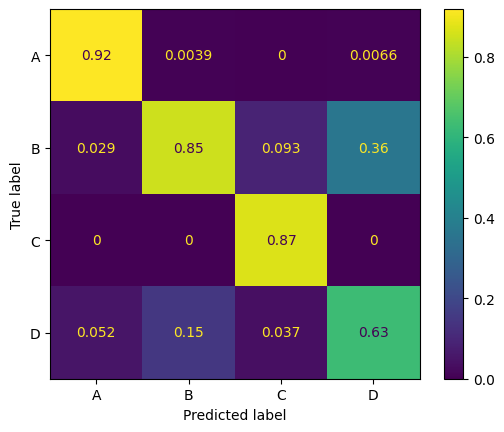

In [15]:
#Predict
y_prediction_free_model = imagenet_free_model.predict(test_data) #for each observation the model returns the probability of belonging to each class
arg_y_free_model = np.argmax(y_prediction_free_model, axis=1) #choose the class with most probability
a = {0:'A',1:'B',2:'C',3:'D'}
# print(list(test_df.label))
# print([a[i] for i in arg_y_INF_model])
result_free = confusion_matrix(list(test_df.label), [a[i] for i in arg_y_free_model], normalize='pred')
cm_display_free = ConfusionMatrixDisplay(confusion_matrix = result_free, display_labels = ['A','B','C','D'])
cm_display_free.plot()
plt.show()

In [16]:
acc_perclass_free = result_free.diagonal()
print("Accuracy per class Model 1")
print(acc_perclass_free)
print("Healthy      Bacterial     Covid     Viral")


Accuracy per class Model 1
[0.91907514 0.84765625 0.87037037 0.63157895]
Healthy      Bacterial     Covid     Viral


In [17]:
print(classification_report(test_df.label, [a[i] for i in arg_y_free_model]))

              precision    recall  f1-score   support

           A       0.92      0.99      0.95       161
           B       0.85      0.77      0.81       282
           C       0.87      1.00      0.93        47
           D       0.63      0.66      0.65       145

    accuracy                           0.82       635
   macro avg       0.82      0.85      0.83       635
weighted avg       0.82      0.82      0.82       635

